# Multi-Lable Classification with MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import os, sys
# sys.path.append(os.pardir)

from anime_classification import MultiLabelClassifier, Adam, Trainer

## Load Vectorized Synopsis/Genre Data

In [2]:
synop_vec = pd.read_csv('../synopsis_vector/synopsis_vector.csv')
synop_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1,-0.115295,-3.925781,0.509277,1.326172,2.685547,1.787109,-1.766602,-1.253906,-1.898438,...,0.862305,-0.738770,-1.120117,-0.728516,1.066406,1.273438,-0.247070,1.378906,1.921875,2.218750
1,5,2.314453,-2.363281,-0.013374,2.705078,1.199219,3.171875,-1.359375,-2.605469,-1.960938,...,0.495850,-0.945801,-0.938965,-0.259766,2.087891,1.500000,-0.221924,0.645508,2.220703,0.959473
2,6,-0.225220,-2.599609,-0.183350,2.042969,1.671875,1.951172,-1.367188,-2.916016,-0.161621,...,-1.436523,-1.022461,-2.535156,-2.455078,2.013672,1.943359,0.623047,1.701172,2.359375,1.232422
3,7,0.844727,-0.527344,0.271484,0.753418,1.576172,2.492188,-1.652344,-2.705078,-2.271484,...,-0.366943,-1.791016,-1.804688,-2.474609,2.880859,0.426514,-0.582520,3.105469,0.839355,1.042969
4,8,1.522461,-2.654297,0.423584,1.816406,2.029297,1.697266,0.608887,-1.333008,-1.022461,...,1.652344,-1.703125,-2.476562,-4.488281,1.402344,0.639160,0.059204,1.250000,2.458984,2.517578


In [3]:
genre_vec = pd.read_csv('../clean_data/genre.csv')
genre_vec.head()

,MAL_ID,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,1,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,5,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Split Train-Test Set

In [4]:
synop_cols = synop_vec.columns.drop('MAL_ID').tolist()
genre_cols = genre_vec.columns.drop('MAL_ID').tolist()

In [5]:
full_vec = pd.merge(synop_vec, genre_vec)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,-0.115295,-3.925781,0.509277,1.326172,2.685547,1.787109,-1.766602,-1.253906,-1.898438,...,0,0,1,0,0,0,0,0,0,0
1,5,2.314453,-2.363281,-0.013374,2.705078,1.199219,3.171875,-1.359375,-2.605469,-1.960938,...,0,0,1,0,0,0,0,0,0,0
2,6,-0.225220,-2.599609,-0.183350,2.042969,1.671875,1.951172,-1.367188,-2.916016,-0.161621,...,0,0,0,0,0,0,0,0,0,0
3,7,0.844727,-0.527344,0.271484,0.753418,1.576172,2.492188,-1.652344,-2.705078,-2.271484,...,0,0,0,0,0,1,0,0,0,0
4,8,1.522461,-2.654297,0.423584,1.816406,2.029297,1.697266,0.608887,-1.333008,-1.022461,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# random shuffle and re-index
full_vec = full_vec.sample(frac=1).reset_index(drop=True)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,2570,-1.090820,-3.431641,1.183594,1.676758,0.704590,1.980469,-1.685547,0.498291,-0.411865,...,0,1,0,0,0,0,0,0,0,0
1,7152,0.321533,-2.117188,-0.482178,2.632812,1.866211,3.966797,-1.171875,-2.564453,-0.966797,...,0,0,0,0,0,0,0,0,0,0
2,12115,1.547852,-1.991211,1.904297,1.661133,0.147583,3.078125,-1.941406,-0.908691,-1.600586,...,0,0,0,0,0,1,0,0,0,0
3,5231,0.522949,-1.998047,-0.202271,2.359375,1.492188,1.136719,-1.423828,-1.595703,-2.873047,...,0,0,0,1,1,0,0,0,0,0
4,37976,1.662109,-2.257812,-0.544434,1.918945,1.360352,2.017578,-0.837891,-0.522949,-1.224609,...,0,0,0,0,0,1,0,0,0,0


In [7]:
train_ratio = 0.7

num_train = int(len(full_vec) * train_ratio)

x_train = full_vec[synop_cols][:num_train].values
t_train = full_vec[genre_cols][:num_train].values

x_test = full_vec[synop_cols][num_train:].values
t_test = full_vec[genre_cols][num_train:].values

del synop_vec, genre_vec, full_vec

## Define Model

In [8]:
input_size  = len(synop_cols)
output_size = len(genre_cols)

model = MultiLabelClassifier(input_size, output_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

## Train Model

In [9]:
num_epochs = 500
batch_size = 100

trainer.fit(x_train, t_train, num_epochs, batch_size)

| 에폭 348 |  반복 21 / 42 | 시간 54[s] | 손실 1.04
| 에폭 348 |  반복 41 / 42 | 시간 54[s] | 손실 0.95
| 에폭 349 |  반복 1 / 42 | 시간 54[s] | 손실 0.87
| 에폭 349 |  반복 21 / 42 | 시간 54[s] | 손실 0.99
| 에폭 349 |  반복 41 / 42 | 시간 54[s] | 손실 1.02
| 에폭 350 |  반복 1 / 42 | 시간 54[s] | 손실 1.11
| 에폭 350 |  반복 21 / 42 | 시간 54[s] | 손실 0.90
| 에폭 350 |  반복 41 / 42 | 시간 54[s] | 손실 1.07
| 에폭 351 |  반복 1 / 42 | 시간 54[s] | 손실 0.66
| 에폭 351 |  반복 21 / 42 | 시간 54[s] | 손실 0.94
| 에폭 351 |  반복 41 / 42 | 시간 54[s] | 손실 0.90
| 에폭 352 |  반복 1 / 42 | 시간 54[s] | 손실 1.20
| 에폭 352 |  반복 21 / 42 | 시간 54[s] | 손실 0.89
| 에폭 352 |  반복 41 / 42 | 시간 54[s] | 손실 0.96
| 에폭 353 |  반복 1 / 42 | 시간 54[s] | 손실 0.78
| 에폭 353 |  반복 21 / 42 | 시간 54[s] | 손실 0.87
| 에폭 353 |  반복 41 / 42 | 시간 54[s] | 손실 1.02
| 에폭 354 |  반복 1 / 42 | 시간 54[s] | 손실 0.80
| 에폭 354 |  반복 21 / 42 | 시간 55[s] | 손실 0.91
| 에폭 354 |  반복 41 / 42 | 시간 55[s] | 손실 1.02
| 에폭 355 |  반복 1 / 42 | 시간 55[s] | 손실 0.74
| 에폭 355 |  반복 21 / 42 | 시간 55[s] | 손실 0.89
| 에폭 355 |  반복 41 / 42 | 시간 55[s] | 손실 

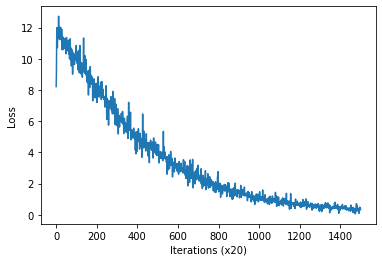

In [10]:
trainer.plot()